In [1]:
import os

# Limit the number of threads for various libraries
os.environ["MKL_NUM_THREADS"] = "12"  # For MKL (used by NumPy)
os.environ["NUMEXPR_NUM_THREADS"] = "12"  # For NumExpr
os.environ["VECLIB_MAXIMUM_THREADS"] = "12"  # For macOS Accelerate
os.environ["OPENBLAS_NUM_THREADS"] = "12"  # For OpenBLAS
os.environ["BLIS_NUM_THREADS"] = "12"  # For BLIS

# Print environment variables to verify
print("OMP_NUM_THREADS:", os.environ.get("OMP_NUM_THREADS"))
print("MKL_NUM_THREADS:", os.environ.get("MKL_NUM_THREADS"))
print("NUMEXPR_NUM_THREADS:", os.environ.get("NUMEXPR_NUM_THREADS"))
print("VECLIB_MAXIMUM_THREADS:", os.environ.get("VECLIB_MAXIMUM_THREADS"))
print("OPENBLAS_NUM_THREADS:", os.environ.get("OPENBLAS_NUM_THREADS"))
print("BLIS_NUM_THREADS:", os.environ.get("BLIS_NUM_THREADS"))

# Set PyTorch threads
import torch
torch.set_num_threads(18)
torch.set_num_interop_threads(18)

OMP_NUM_THREADS: None
MKL_NUM_THREADS: 12
NUMEXPR_NUM_THREADS: 12
VECLIB_MAXIMUM_THREADS: 12
OPENBLAS_NUM_THREADS: 12
BLIS_NUM_THREADS: 12


In [2]:
# WrappedProteinDataset & PCAExplainability - Usage Demo
# ======================================================
# This notebook demonstrates how to use WrappedProteinDataset and PCAExplainability
# to perform dimensionality reduction and interpret protein embedding data.

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

from project_root.dataset.dataset_loader import DatasetLoader
from project_root.dataset.protein_dataset import ProteinDataset
from project_root.dataset.wrapped_protein_dataset import WrappedProteinDataset
from project_root.utils.visualization import DataVisualizer

In [3]:
# ------------------------------------------------------
# 📥 1. Load Dataset and Embeddings
# ------------------------------------------------------

# Define data path
path_dataset_folder = "../DATASETS/"

# Load data
loader = DatasetLoader(path_dataset_folder)
df = loader.load_dataframe()
embeddings, attention_weights = loader.load_embeddings_and_attention()

# Create ProteinDataset instance
protein_dataset = ProteinDataset(df, embeddings, attention_weights, solve_inconsistencies=True)

(877, 877)
(877, 877)
(1598, 1598)
(723, 723)
(723, 723)
(723, 723)
(723, 723)
(918, 918)
(918, 918)
(431, 431)
(431, 431)
(431, 431)
(431, 431)
(396, 396)
(396, 396)
(944, 944)
(944, 944)
(1077, 1077)
(1077, 1077)
(696, 696)
(696, 696)
(696, 696)
(696, 696)
(1248, 1248)
(548, 548)
(548, 548)
(548, 548)
(548, 548)
(548, 548)
(548, 548)
(548, 548)
(548, 548)
(760, 760)
(760, 760)
(760, 760)
(760, 760)
(315, 315)
(1294, 1294)
(467, 467)
(467, 467)
(83, 83)
(561, 561)
(857, 857)
(857, 857)
(857, 857)
(857, 857)
(857, 857)
(857, 857)
(857, 857)
(857, 857)
(718, 718)
(718, 718)
(718, 718)
(718, 718)
(718, 718)
(718, 718)
(718, 718)
(718, 718)
(870, 870)
(870, 870)
(870, 870)
(870, 870)
(1245, 1245)
(1245, 1245)
(1245, 1245)
(1245, 1245)
(898, 898)
(898, 898)
(898, 898)
(898, 898)
(898, 898)
(898, 898)
(898, 898)
(898, 898)
(819, 819)
(819, 819)
(819, 819)
(819, 819)
(819, 819)
(819, 819)
(819, 819)
(819, 819)
(1142, 1142)
(1142, 1142)
(1142, 1142)
(1142, 1142)
(314, 314)
(314, 314)
(314, 31

In [4]:
print("ProteinDataset:")
print(f"Print ids length: {len(protein_dataset.ids)}")
print(f"Print levels length: {len(protein_dataset.labels)}")
print(f"Print embeddings shape: {len(protein_dataset.embeddings)}")
print(f"Print attention weights shape: {len(protein_dataset.attention_weights)}")

ProteinDataset:
Print ids length: 1219
Print levels length: 1219
Print embeddings shape: 1219
Print attention weights shape: 1219


In [5]:
# ------------------------------------------------------
# 🧪 2. Create WrappedProteinDataset with Configurations
# ------------------------------------------------------

# ➤ Option A: Use PCA for both embeddings and attention weights
dataset_pca = WrappedProteinDataset(
    dataset=protein_dataset,
    reduce_method='pca',              # or 'tsne'
    pca_method='threshold',           # 'threshold', 'derivative', 'custom'
    threshold=0.95,
    random_projection_dim=800        # Random projection dim before PCA on attention weights
)

Converting embeddings and attention weights to NumPy arrays...
Applying random projection to reduce attention weights from 6255001 to 800 dimensions...
Applying dimensionality reduction using pca...



--- Test Case 1: select_data({'embedding': True}) ---


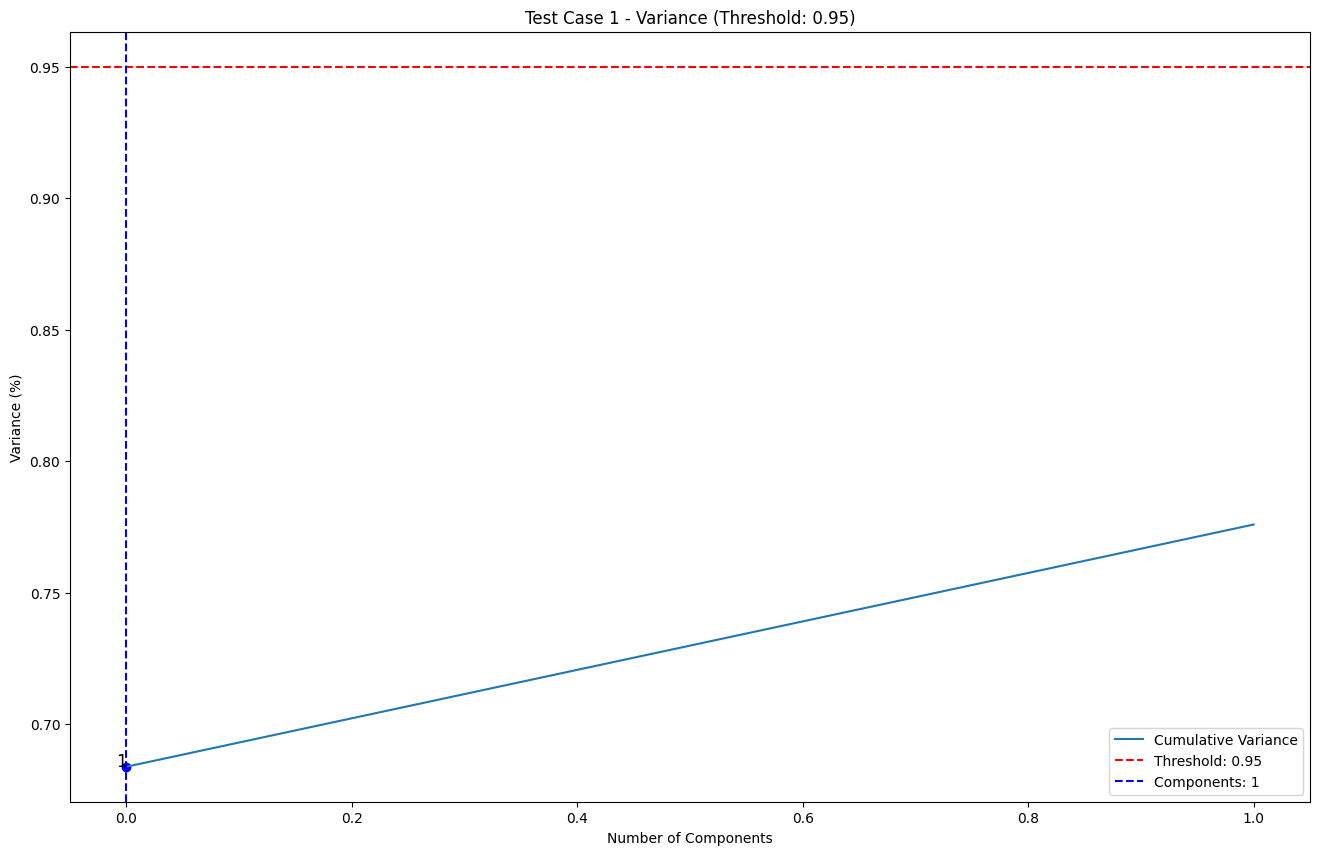

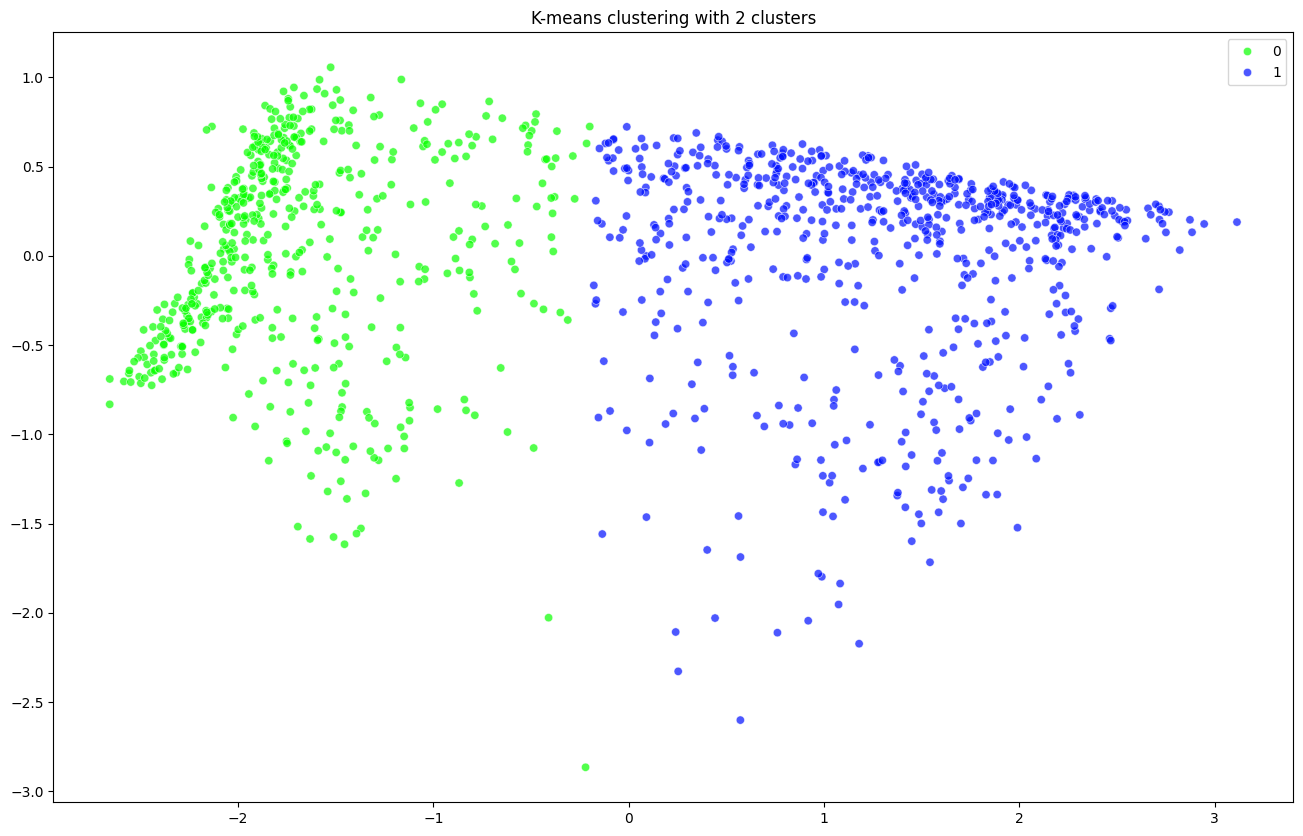

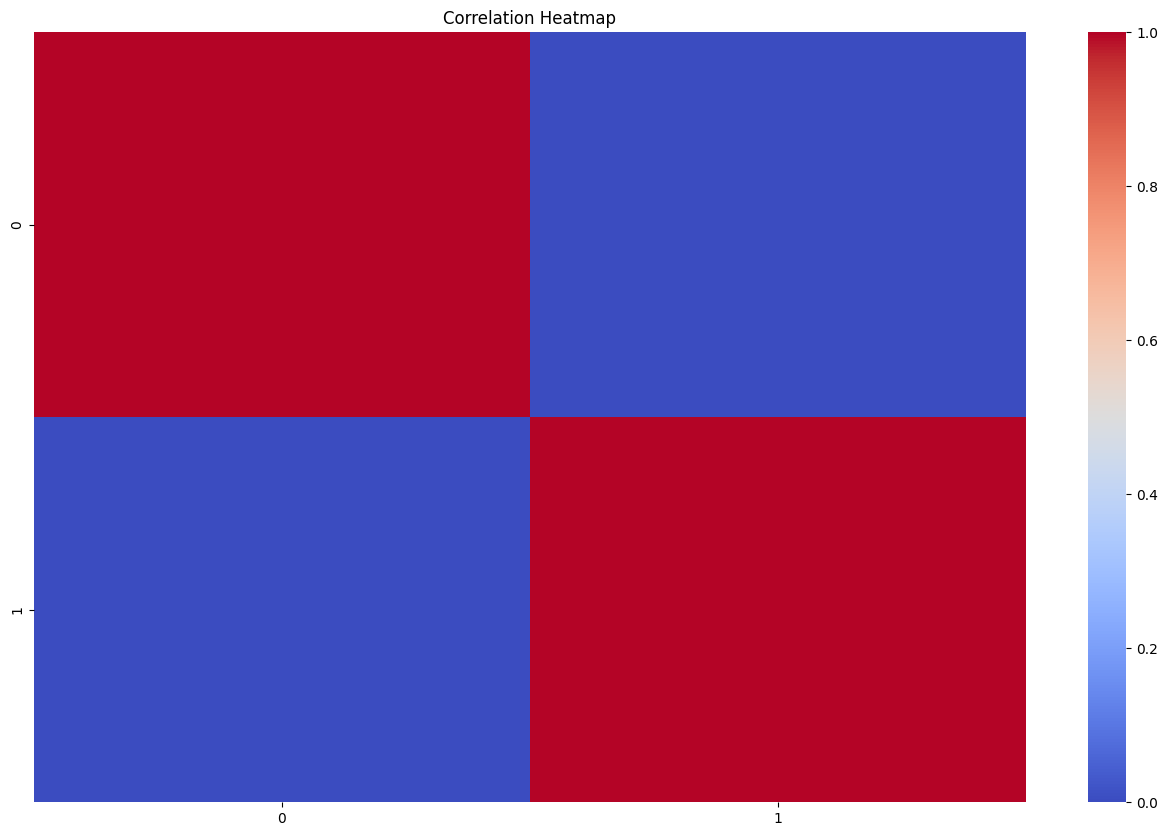


--- Test Case 2: select_data({'attention_weights': True}) ---


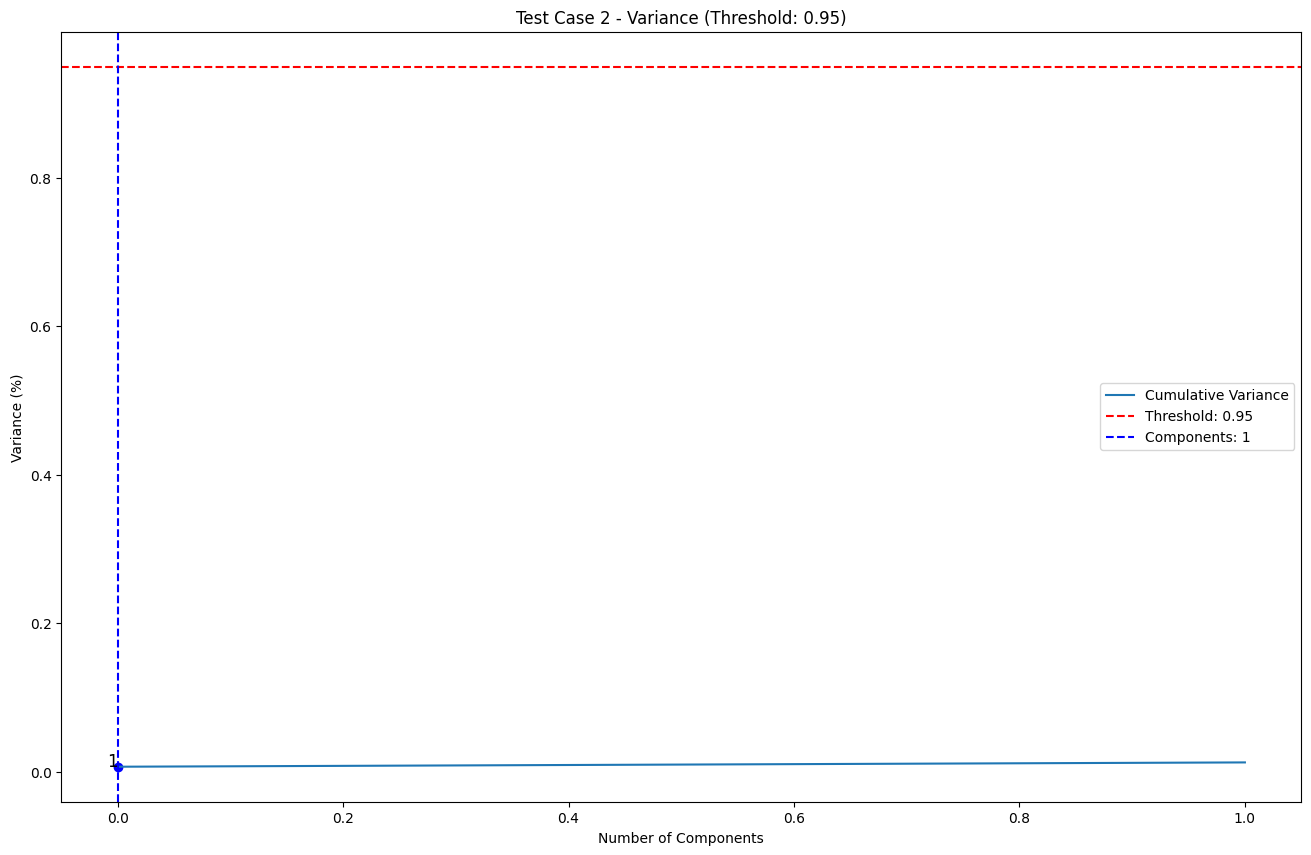

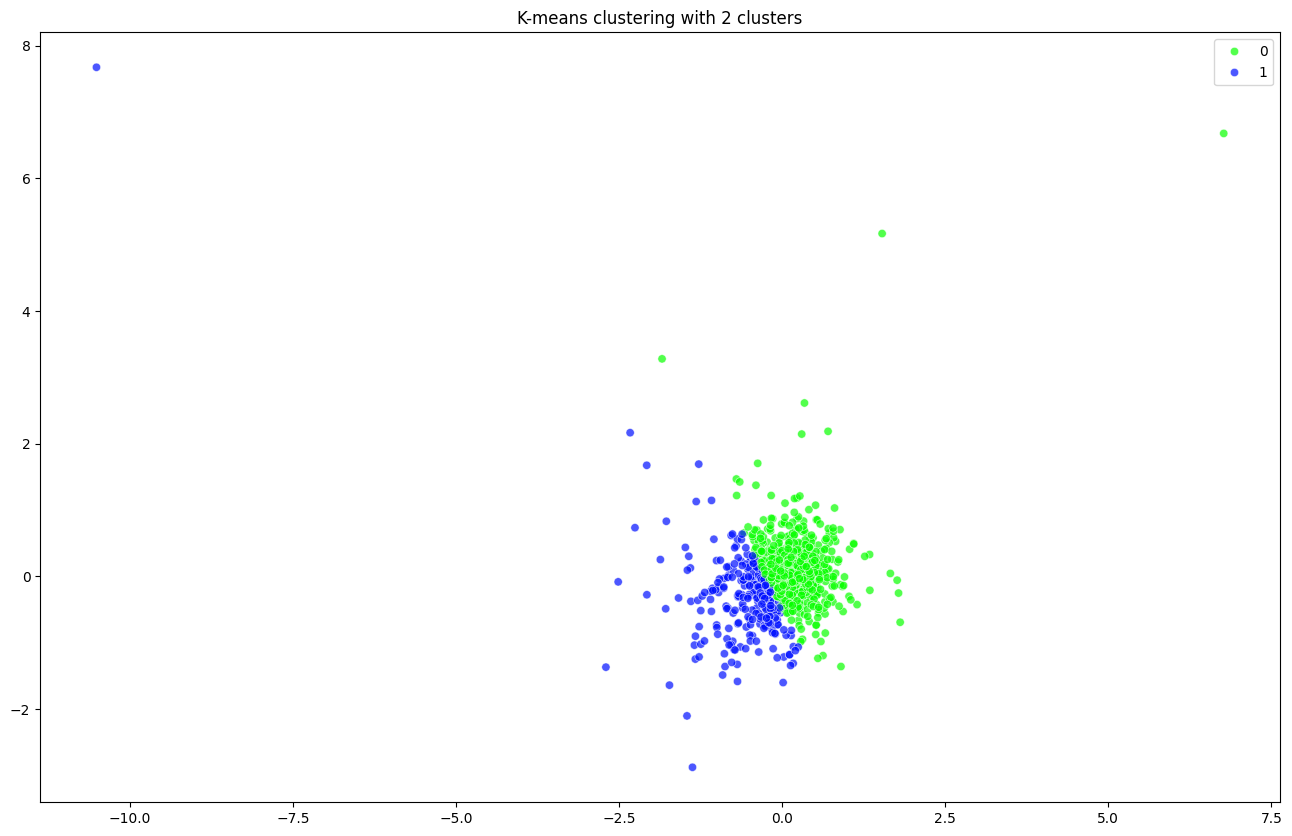

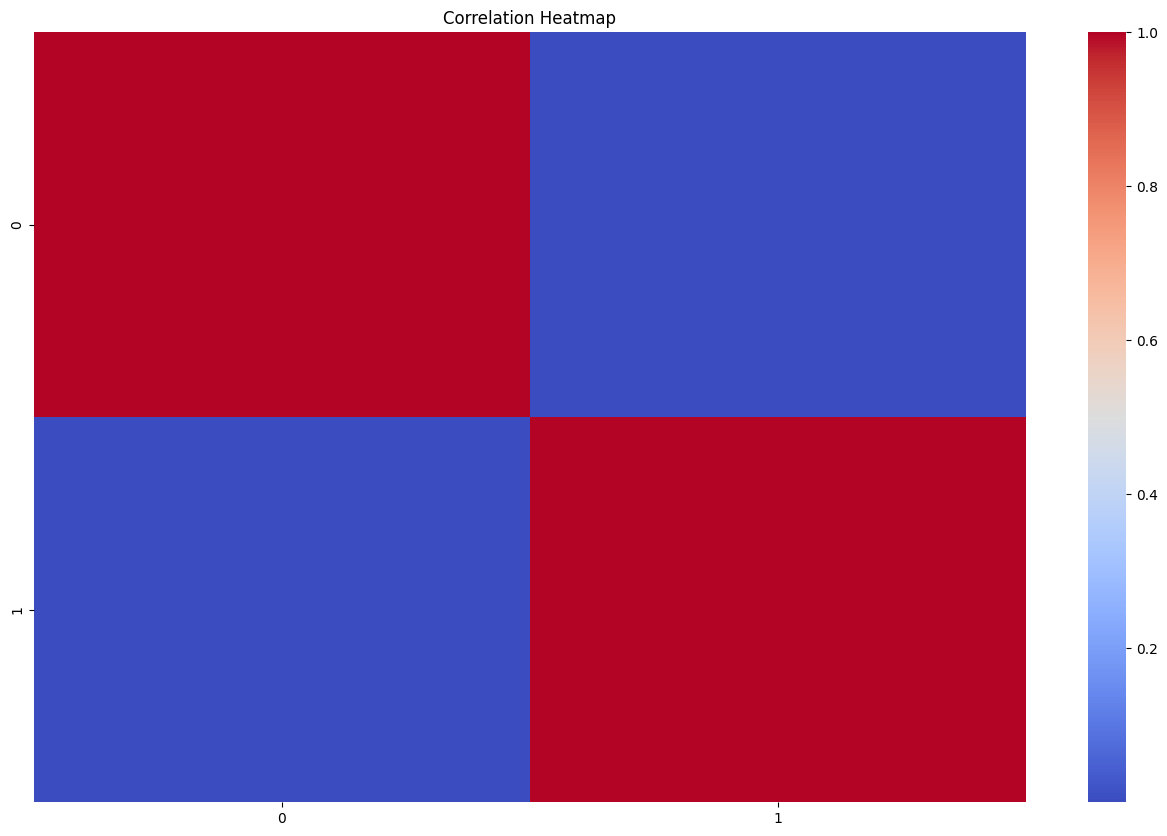


--- Test Case 3: select_data({'embedding': True, 'attention_weights': True}) ---


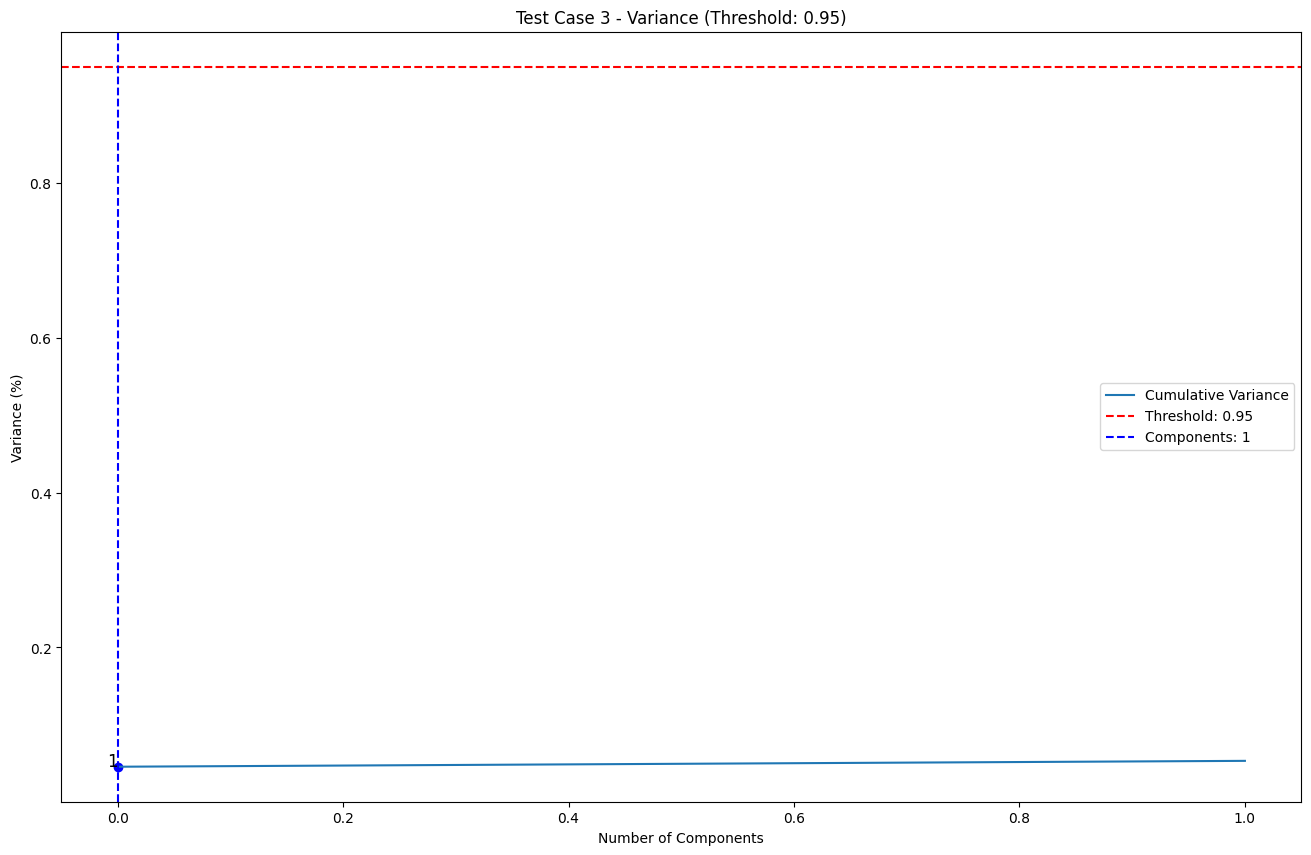

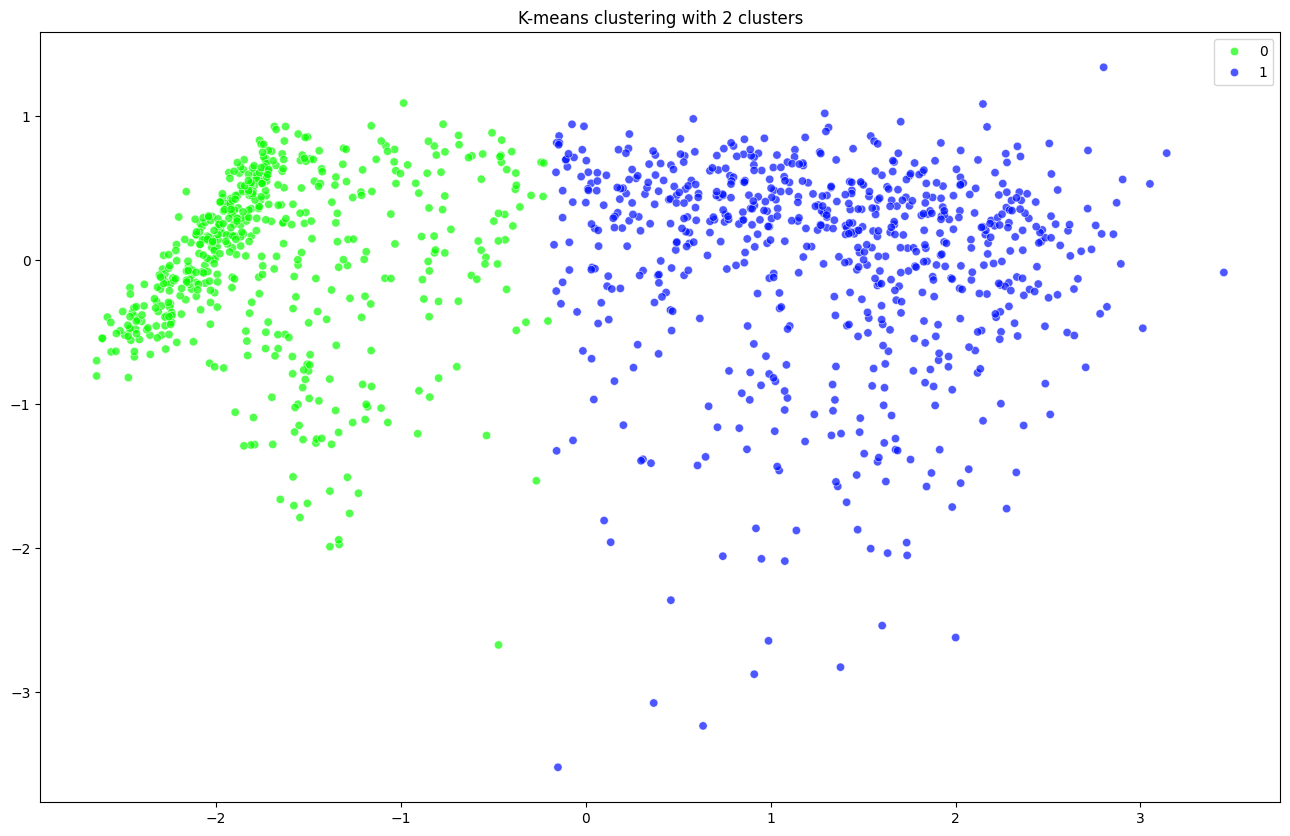

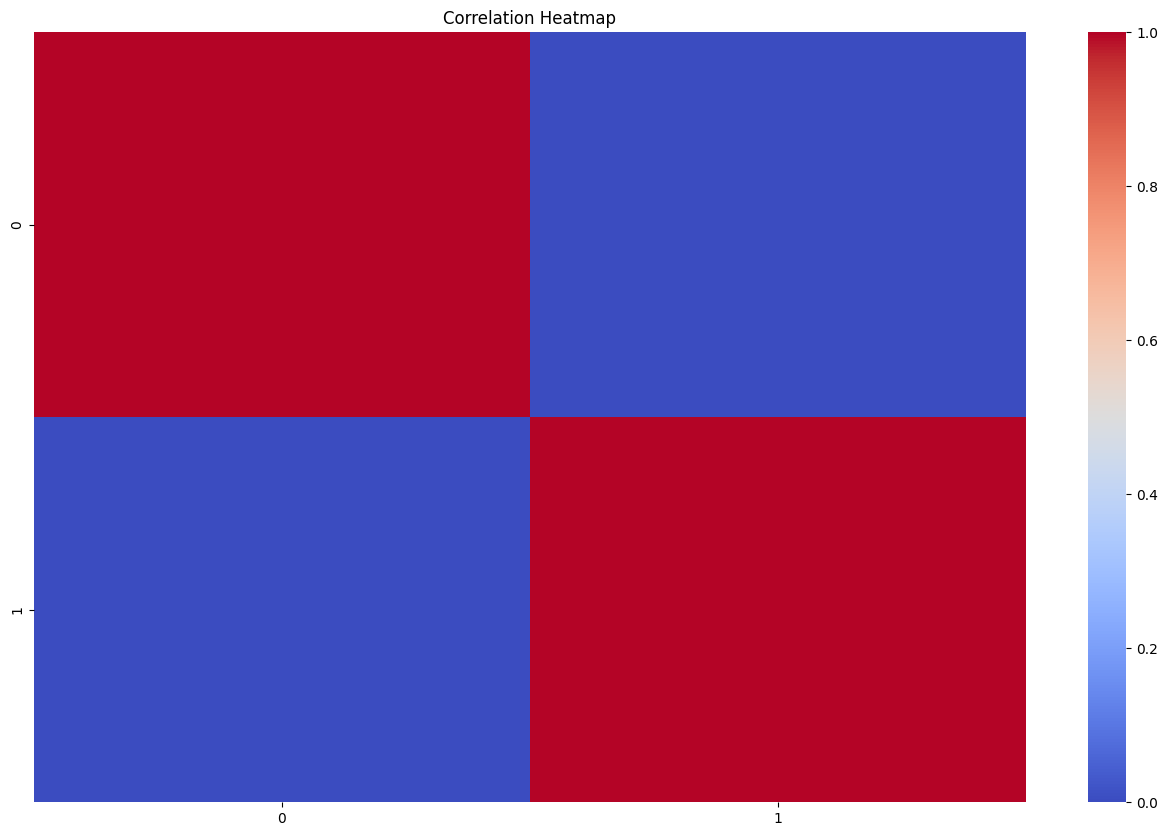


--- Test Case 4: select_data({'attention_weights': True, 'target_column': True}) ---
❌ Test Case 4 failed: axis 1 is out of bounds for array of dimension 1

--- Test Case 5: select_data({'embedding': True, 'attention_weights': True, 'target_column': True}) ---
❌ Test Case 5 failed: axis 1 is out of bounds for array of dimension 1

--- Test Case 6: select_data({'embedding': True, 'attention_weights': True, 'additional_columns': ['length']}) ---
❌ Test Case 6 failed: Attribute 'length' not found in dataframe.


In [6]:
# Step 3: Test all select_data() combinations and run plots
def test_select_data_combinations():
    combinations = [
        {'embedding': True},
        {'attention_weights': True},
        {'embedding': True, 'attention_weights': True},
        {'attention_weights': True, 'target_column': True},
        {'embedding': True, 'attention_weights': True, 'target_column': True},
        {'embedding': True, 'attention_weights': True, 'additional_columns': ['length']},
    ]

    for i, combo in enumerate(combinations):
        print(f"\n--- Test Case {i+1}: select_data({combo}) ---")
        try:
            data = dataset_pca.select_data(**combo)
            if isinstance(data, list):
                data = np.array(data)
            if data.shape[1] > 2:
                # Reduce to 2D for plotting
                pca = PCA(n_components=2)
                reduced = pca.fit_transform(data)
                DataVisualizer.plot_variance_explained(pca, title=f"Test Case {i+1} - Variance")
                DataVisualizer.plot_kmeans(reduced, n_clusters=2)
                DataVisualizer.plot_correration_heatmap(reduced)
            else:
                print("Data too small for PCA or plotting.")
        except Exception as e:
            print(f"❌ Test Case {i+1} failed: {e}")

# Run the tests
test_select_data_combinations()

In [ ]:

# ➤ Option C: Use t-SNE for visual exploration
dataset_tsne = WrappedProteinDataset(
    dataset=protein_dataset,
    reduce_method='tsne'            # Use only for 2D plotting, not for training
)

Converting embeddings and attention weights to NumPy arrays...


In [ ]:
# ------------------------------------------------------
# 🌀 4. Cluster Visualization Example
# ------------------------------------------------------

# Visualize clustering using KMeans on combined PCA-reduced features
dataset_pca.plot_kmeans(n_clusters=2, attribute='Class', embedding=True, attention_weights=True)

# Visualize clustering on t-SNE-reduced embeddings
dataset_tsne.plot_kmeans(n_clusters=2, attribute='Class', embedding=True, attention_weights=False)

# ------------------------------------------------------
# 📌 Notes:
# ------------------------------------------------------
# - reduce_method: Choose 'pca', 'tsne', or None
# - pca_method: Use 'threshold' for 95% variance, 'derivative' for elbow
# - random_projection_dim: Optional projection to speed up PCA on high-dim attention
# - get PCA object using: PCA().fit(data)
# - Use PCAExplainability for detailed analysis of components and features
# - Use WrappedProteinDataset as input for training or further analysis

print("✅ Demo complete.")

ValueError: array length 1219 does not match index length 1249

<Figure size 1600x1000 with 0 Axes>